```mermaid
flowchart TD

    generate[Generate Structure from SMILES]
    label[Compute Energies using xTB]
    splitDataSet[Split dataset into train & test]
    train[Train a GradientBoostingRegressor]
    evaluate[Evaluate the Model on different metrics]

    generate-->label-->splitDataSet-->train-->evaluate
```

In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np
import zndraw
from dscribe.descriptors import SOAP
from rdkit import Chem
from rdkit2ase import rdkit2ase
from rdkit.Chem import AllChem
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xtb.ase.calculator import XTB

In [2]:
def get_conformers() -> list[ase.Atoms]:
    """Compute conformers of ethanol."""
    mol = Chem.MolFromSmiles("CCO")
    mol = Chem.AddHs(mol)

    AllChem.EmbedMultipleConfs(
        mol,
        numConfs=200,
        randomSeed=42,
        maxAttempts=100,
    )
    return [rdkit2ase(x) for x in mol.GetConformers()]

In [3]:
def compute_energies(atoms_list) -> list[ase.Atoms]:
    """Compute the energies of a list of atoms objects using xTB"""
    for atoms in atoms_list:
        atoms.calc = XTB(method="GFN1-xTB")
        atoms.get_potential_energy()

    energies = [x.get_potential_energy() for x in atoms_list]
    fig, ax = plt.subplots()
    ax.plot(energies)
    ax.set_xlabel("# Conformation")
    ax.set_ylabel("Energy / eV")

In [4]:
def get_datasets(atoms_list):
    """Convert atoms to SOAP features and split into train/test sets."""
    soap = SOAP(
        species=set(atoms_list[0].get_chemical_symbols()),
        periodic=False,
        r_cut=5.0,
        n_max=5,
        l_max=5,
    )
    features = soap.create(atoms_list)
    features = features.reshape((len(atoms_list), -1))
    targets = np.array([atoms.get_potential_energy() for atoms in atoms_list])

    X_train, X_test, y_train, y_test = train_test_split(
        features, targets, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test

In [5]:
def train_model(X_train, y_train):
    """Train a gradient boosting regressor on the training data."""
    gb_model = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, random_state=42
    )
    gb_model.fit(X_train, y_train)
    return gb_model


def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test data."""
    gb_predictions = model.predict(X_test)
    gb_mse = mean_squared_error(y_test, gb_predictions)
    print(f"Gradient Boosting MSE: {gb_mse}")
    fig, ax = plt.subplots()
    ax.scatter(gb_predictions, y_test)
    ax.plot(y_test, y_test)
    ax.set_xlabel("xTB Energy / eV")
    ax.set_ylabel("predicted Energy / eV")

Run the code.

Gradient Boosting MSE: 0.0006177933596924433


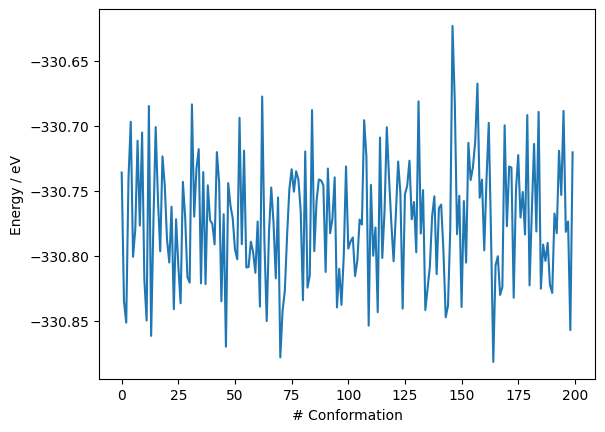

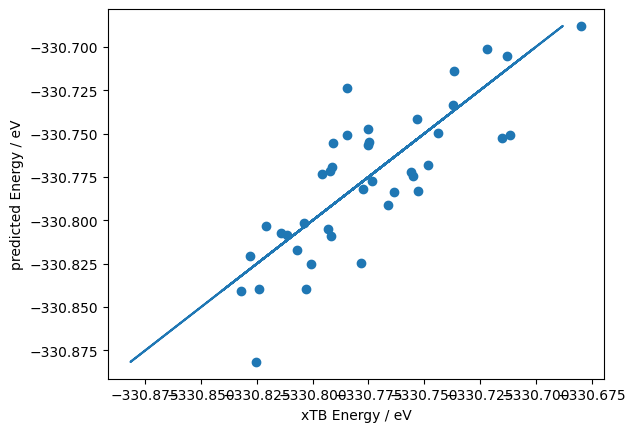

In [6]:
atoms = get_conformers()
compute_energies(atoms)

X_train, X_test, y_train, y_test = get_datasets(atoms)

model = train_model(X_train, y_train)
_ = evaluate_model(model, X_test, y_test)